# **Deep Learning | Assignment 1**

### *Relevant Imports*

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

### ***Loading and Prepering the Data***

In [1]:
# Path for saving the data
image_path = './' 

torch.manual_seed(1)

transform = transforms.Compose([transforms.ToTensor()]) 


# Loading the train and test sets
mnist_train_dataset = MNIST(
    root=image_path,
    train=True,
    transform=transform,
    download=True
)


mnist_test_dataset = MNIST(
    root=image_path,
    train=False,
    transform=transform,
    download=False
)

print(len(mnist_train_dataset))
print(len(mnist_test_dataset))

train_size = int(0.8 * len(mnist_train_dataset))
val_size = len(mnist_train_dataset) - train_size

mnist_train_dataset, mnist_val_dataset = random_split(mnist_train_dataset, [train_size, val_size])


# Printing the sizes of the sets
print(f"Training set size: {len(mnist_train_dataset)}")
print(f"Validation set size: {len(mnist_val_dataset)}")
print(f"Test set size: {len(mnist_test_dataset)}")



60000
10000
Training set size: 48000
Validation set size: 12000
Test set size: 10000


### *Visualizing the images*

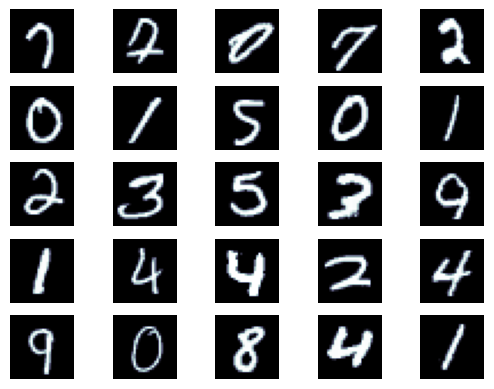

In [2]:
def plot_images(images):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows * cols):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

N_IMAGES = 25
images = []

for i in range(N_IMAGES):
    image, label = mnist_train_dataset[i]
    images.append(image)

plot_images(images)


### **Building the Model**


In [3]:
def get_model(image_shape, hidden_units, activation_fn):
    input_size = image_shape[0] * image_shape[1] * image_shape[2]
    all_layers = [nn.Flatten()]
    for hidden_unit in hidden_units:
        layer = nn.Linear(input_size, hidden_unit)
        all_layers.append(layer)
        all_layers.append(activation_fn())
        input_size = hidden_unit

    all_layers.append(nn.Linear(hidden_units[-1], 10))
    all_layers.append(nn.Softmax(dim=1))
    model = nn.Sequential(*all_layers)
    return model


In [4]:
def get_accuracy (probs, labels):
   actual_predictions = torch.argmax(probs,dim=1)
   equality = (labels == actual_predictions).sum()

   return equality.item()


### *The Training Function*

In [5]:
def model_train(n_epochs, train_loader, val_loader, model, optimizer, loss_fn):
    model.train()
    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []

    for epoch in range(n_epochs):
        train_loss = 0.0
        train_accuracy = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            train_accuracy += get_accuracy(output, target)
        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy /= len(train_loader.dataset)
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)

        # Evaluate on validation set
        val_loss, val_accuracy = validate(model, val_loader, loss_fn)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)

        print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tTraining Accuracy: {train_accuracy:.6f}')
        print(f'Epoch: {epoch+1} \tValidation Loss: {val_loss:.6f} \tValidation Accuracy: {val_accuracy:.6f}')

    return model, train_accuracy_list, train_loss_list, val_accuracy_list, val_loss_list

### *Model Evaluation*

In [6]:
def validate(model, loader, loss_fn):
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    for data, target in loader:
        with torch.no_grad():
            output = model(data)
            loss = loss_fn(output, target)
            val_loss += loss.item() * data.size(0)
            val_accuracy += get_accuracy(output, target)
    val_loss /= len(loader.dataset)
    val_accuracy /= len(loader.dataset)
    return val_loss, val_accuracy

### *Model Evaluation | Test*

In [7]:
def test(n_epochs, model, loader, loss_fn):
    loss_list = []
    accuracy_list = []
    model.eval()
    with torch.no_grad():
        for epoch in range(n_epochs):
            test_loss = 0.0
            test_accuracy = 0.0
            for data, target in loader:
                with torch.no_grad():
                    output = model(data)
                    loss = loss_fn(output, target)
                    test_loss += loss.item() * data.size(0)
                    test_accuracy += get_accuracy(output, target)
            test_loss = test_loss / len(loader.dataset)
            test_accuracy = test_accuracy / len(loader.dataset)
            loss_list.append(test_loss)
            accuracy_list.append(test_accuracy)
            print(f'Epoch: {epoch+1} \tTest Loss: {test_loss:.6f} \tTest Accuracy: {test_accuracy:.6f}')
    return model, accuracy_list, loss_list


### *Visualizing Accuracy and Loss Charts | Train*

In [8]:
def plot_charts(train_accuracy_list, train_loss_list, val_accuracy_list, val_loss_list):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot Loss
    axes[0].plot(train_loss_list, label='Training Loss', lw=2)
    axes[0].plot(val_loss_list, label='Validation Loss', lw=2)
    axes[0].set_title('Loss', size=15)
    axes[0].set_xlabel('Epoch', size=12)
    axes[0].set_ylabel('Loss', size=12)
    axes[0].grid(True)
    axes[0].legend()

    # Plot Accuracy
    axes[1].plot(train_accuracy_list, label='Training Accuracy', lw=2)
    axes[1].plot(val_accuracy_list, label='Validation Accuracy', lw=2)
    axes[1].set_title('Accuracy', size=15)
    axes[1].set_xlabel('Epoch', size=12)
    axes[1].set_ylabel('Accuracy', size=12)
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()


### *Visualizing Accuracy and Loss Charts | Test*

In [9]:
def plot_charts_test(test_accuracy_list, test_loss_list):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    # Plot Loss
    axes[0].plot(test_loss_list, label='Test', lw=2)
    axes[0].set_title('Loss', size=15)
    axes[0].set_xlabel('Epoch', size=12)
    axes[0].set_ylabel('Loss', size=12)
    axes[0].grid(True)
    axes[0].legend()

    # Plot Accuracy
    axes[1].plot(test_accuracy_list, label='Test Accuracy', lw=2)
    axes[1].set_title('Accuracy', size=15)
    axes[1].set_xlabel('Epoch', size=12)
    axes[1].set_ylabel('Accuracy', size=12)
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()


## Trying Different Combinations

---

### **First Combination**

- **hidden_units**: (50, 20)
  - Two hidden layers.
  first hidden layer = 50 units;
  second hidden layer = 20 units

- **num_epochs**: 10

- **batch_size**: 16

- **learning_rate**: 0.008

- **loss_fn**: CrossEntropyLoss

- **optimizer**: Adam

- **activation_fn**: ReLU



### **Second Combination**

- **hidden_units**: (100, 70, 30)
  - (Number of layers = 3, hidden_size_layer1 = 100, hidden_size_layer2 = 70, hidden_size_layer3 = 30)
  - The model will have three hidden layers. The first hidden layer has 100 units. The second hidden layer has 70 units. The third hidden layer has 30 units.

- **num_epochs**: 15

- **batch_size**: 20

- **learning_rate**: 0.001

- **loss_fn**: CrossEntropyLoss

- **optimizer**: Adam

- **activation_fn**: ReLU



### **Third Combination**

- **hidden_units**: (180, 140, 100, 70)
  - Number of layers = 4, hidden layer 1 = 180, hidden layer 2 = 140, hidden layer 3 = 100, hidden layer 4 = 70)
- **num_epochs**: 17

- **batch_size**: 22

- **learning_rate**: 0.0001

- **loss_fn**: CrossEntropyLoss

- **optimizer**: SGD

- **activation_fn**: Tanh

### *Expectation*
The expectation is that the second combination will produce the best results. The reason is that, even with a better learning rate, the third combination might overfit due to an excessive number of layers and neurons. Conversely, the first combination might underfit for the same reason.

Training with params: {'num_model': 1, 'hidden_units': [50, 20], 'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.008, 'n_epochs': 10, 'batch_size': 16, 'loss_fn': CrossEntropyLoss()}
Epoch: 1 	Training Loss: 1.622540 	Training Accuracy: 0.839104
Epoch: 1 	Validation Loss: 1.570072 	Validation Accuracy: 0.890583
Epoch: 2 	Training Loss: 1.579904 	Training Accuracy: 0.880917
Epoch: 2 	Validation Loss: 1.564512 	Validation Accuracy: 0.896500
Epoch: 3 	Training Loss: 1.573868 	Training Accuracy: 0.887167
Epoch: 3 	Validation Loss: 1.564401 	Validation Accuracy: 0.896667
Epoch: 4 	Training Loss: 1.577700 	Training Accuracy: 0.883271
Epoch: 4 	Validation Loss: 1.553877 	Validation Accuracy: 0.907167
Epoch: 5 	Training Loss: 1.574689 	Training Accuracy: 0.886312
Epoch: 5 	Validation Loss: 1.572409 	Validation Accuracy: 0.888583
Epoch: 6 	Training Loss: 1.579969 	Training Accuracy: 0.881104
Epoch: 6 	Validation Loss: 1.570245 	

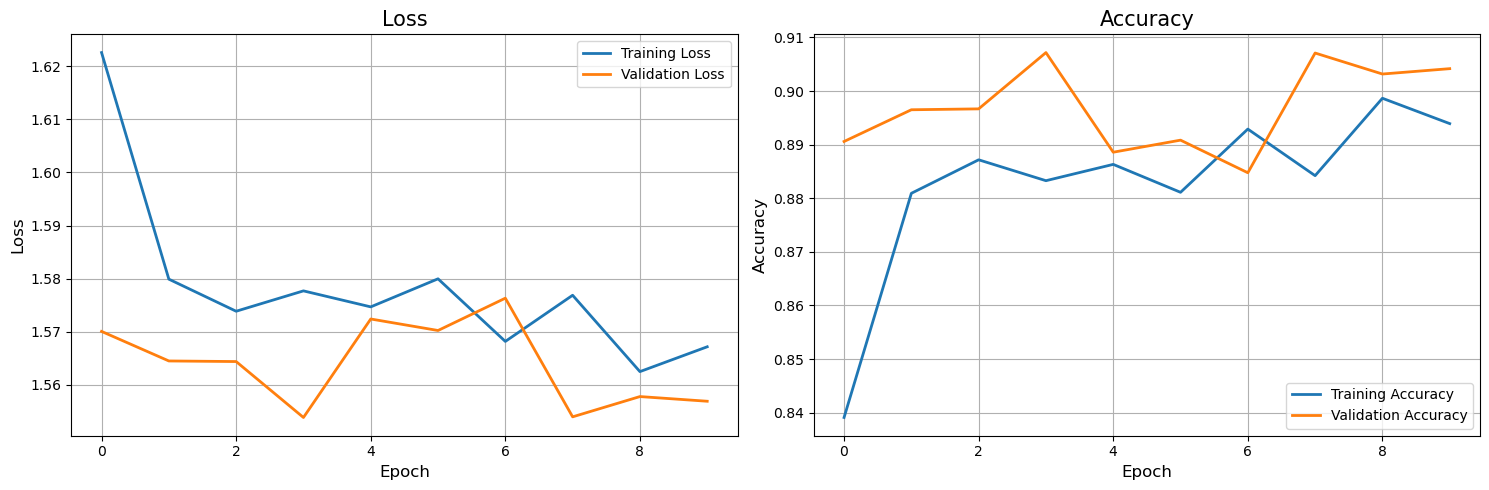

Training with params: {'num_model': 2, 'hidden_units': [100, 70, 30], 'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'n_epochs': 15, 'batch_size': 20, 'loss_fn': CrossEntropyLoss()}
Epoch: 1 	Training Loss: 1.599993 	Training Accuracy: 0.872292
Epoch: 1 	Validation Loss: 1.533210 	Validation Accuracy: 0.929667
Epoch: 2 	Training Loss: 1.527534 	Training Accuracy: 0.935125
Epoch: 2 	Validation Loss: 1.516876 	Validation Accuracy: 0.945250
Epoch: 3 	Training Loss: 1.513694 	Training Accuracy: 0.948542
Epoch: 3 	Validation Loss: 1.511609 	Validation Accuracy: 0.950667
Epoch: 4 	Training Loss: 1.507453 	Training Accuracy: 0.954208
Epoch: 4 	Validation Loss: 1.510826 	Validation Accuracy: 0.950250
Epoch: 5 	Training Loss: 1.501344 	Training Accuracy: 0.960146
Epoch: 5 	Validation Loss: 1.504693 	Validation Accuracy: 0.956333
Epoch: 6 	Training Loss: 1.499110 	Training Accuracy: 0.962021
Epoch: 6 	Validation Loss: 1.506

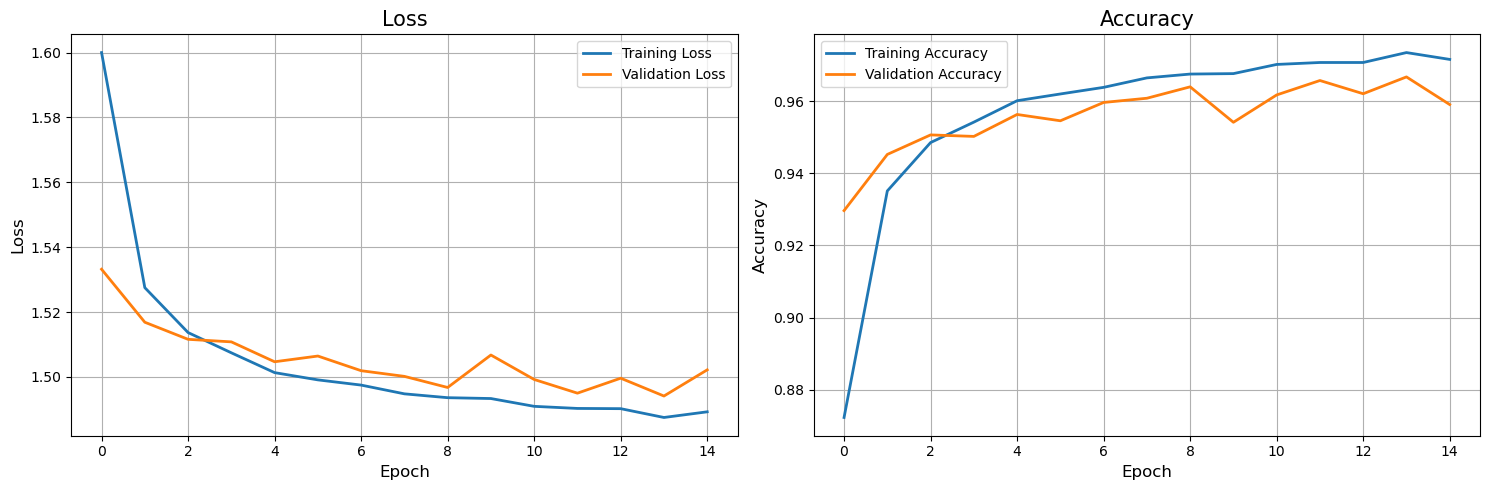

Training with params: {'num_model': 3, 'hidden_units': [180, 140, 100, 70], 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'lr': 0.0001, 'n_epochs': 17, 'batch_size': 22, 'loss_fn': CrossEntropyLoss()}
Epoch: 1 	Training Loss: 2.302479 	Training Accuracy: 0.072438
Epoch: 1 	Validation Loss: 2.302516 	Validation Accuracy: 0.073250
Epoch: 2 	Training Loss: 2.302438 	Training Accuracy: 0.073771
Epoch: 2 	Validation Loss: 2.302475 	Validation Accuracy: 0.075583
Epoch: 3 	Training Loss: 2.302398 	Training Accuracy: 0.075271
Epoch: 3 	Validation Loss: 2.302434 	Validation Accuracy: 0.077167
Epoch: 4 	Training Loss: 2.302357 	Training Accuracy: 0.076646
Epoch: 4 	Validation Loss: 2.302393 	Validation Accuracy: 0.079417
Epoch: 5 	Training Loss: 2.302317 	Training Accuracy: 0.078417
Epoch: 5 	Validation Loss: 2.302353 	Validation Accuracy: 0.080833
Epoch: 6 	Training Loss: 2.302276 	Training Accuracy: 0.080167
Epoch: 6 	Validation Loss: 

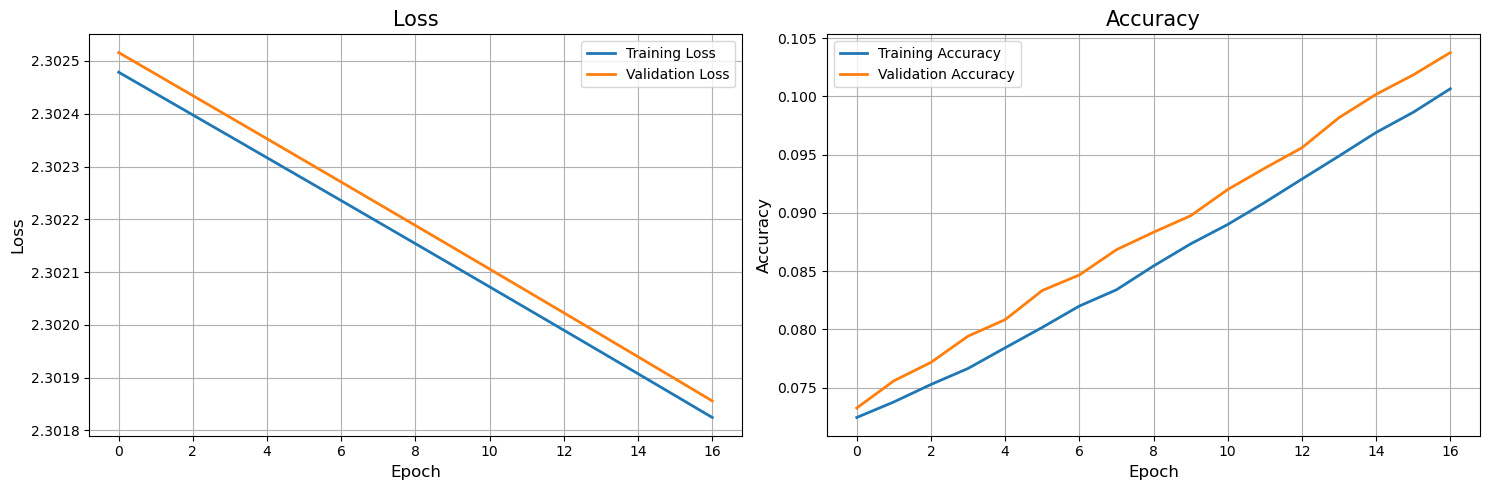

The best model in accuracy: 2 with accuracy: 0.96675
The best model in loss: 2 with loss: 1.4941334235668182


In [10]:
# @title Training the Model
# Hyperparameters for the Test
hyperparameters = [
    {'num_model': 1, 'hidden_units': [50,20], 'activation_fn': nn.ReLU, 'optimizer': optim.Adam, 'lr': 0.008, 'n_epochs': 10, 'batch_size': 16, 'loss_fn': nn.CrossEntropyLoss()},
    {'num_model': 2, 'hidden_units': [100, 70,30], 'activation_fn': nn.ReLU, 'optimizer': optim.Adam, 'lr': 0.001, 'n_epochs': 15, 'batch_size': 20, 'loss_fn': nn.CrossEntropyLoss()},
    {'num_model': 3, 'hidden_units': [180, 140,100,70], 'activation_fn': nn.Tanh, 'optimizer': optim.SGD, 'lr': 0.0001, 'n_epochs': 17, 'batch_size': 22, 'loss_fn': nn.CrossEntropyLoss()},
]

# Training and validating multiple models
best_model_min_loss = None
best_model_max_accuracy = None
best_val_loss = float('inf')
best_val_accuracy = 0.0
best_model_loss=0
best_model_accuracy=0
for params in hyperparameters:

    print(f"Training with params: {params}")
    model = get_model((1, 28, 28), params['hidden_units'], params['activation_fn'])
    optimizer = params['optimizer'](model.parameters(), lr=params['lr'])
    train_loader = DataLoader(mnist_train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(mnist_val_dataset, batch_size=params['batch_size'], shuffle=False)


    model, train_accuracy_list, train_loss_list, val_accuracy_list, val_loss_list = model_train(
        params['n_epochs'], train_loader, val_loader, model, optimizer, params['loss_fn'])

    if min(val_loss_list) < best_val_loss:
        best_val_loss = min(val_loss_list)
        best_model_min_loss = model
        best_model_loss=params['num_model']

    if max(val_accuracy_list) > best_val_accuracy and max(val_accuracy_list) < 1.0:
        best_val_accuracy = max(val_accuracy_list)
        best_model_max_accuracy = model
        best_model_accuracy=params['num_model']

    plot_charts(train_accuracy_list, train_loss_list, val_accuracy_list, val_loss_list)

print(f'The best model in accuracy: {best_model_accuracy} with accuracy: {best_val_accuracy}')
print(f'The best model in loss: {best_model_loss} with loss: {best_val_loss}')

### **Second Combination**

After trying several optimizers and activation functions, we will continue to work with Model 2, as it was the easiest and most productive to work with. Now, we will try changing the learning rates and the number of epochs to achieve the best result. We will test 3 learning rates with 3 different numbers of epochs each.

Training with params: {'num_model': 1, 'hidden_units': [100, 70, 30], 'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'n_epochs': 10, 'batch_size': 20, 'loss_fn': CrossEntropyLoss()}
Epoch: 1 	Training Loss: 1.605539 	Training Accuracy: 0.865292
Epoch: 1 	Validation Loss: 1.538671 	Validation Accuracy: 0.924667
Epoch: 2 	Training Loss: 1.530266 	Training Accuracy: 0.932292
Epoch: 2 	Validation Loss: 1.526308 	Validation Accuracy: 0.936083
Epoch: 3 	Training Loss: 1.517018 	Training Accuracy: 0.945333
Epoch: 3 	Validation Loss: 1.512083 	Validation Accuracy: 0.949417
Epoch: 4 	Training Loss: 1.509899 	Training Accuracy: 0.951688
Epoch: 4 	Validation Loss: 1.509323 	Validation Accuracy: 0.952167
Epoch: 5 	Training Loss: 1.504255 	Training Accuracy: 0.957250
Epoch: 5 	Validation Loss: 1.509272 	Validation Accuracy: 0.951833
Epoch: 6 	Training Loss: 1.500240 	Training Accuracy: 0.960979
Epoch: 6 	Validation Loss: 1.502

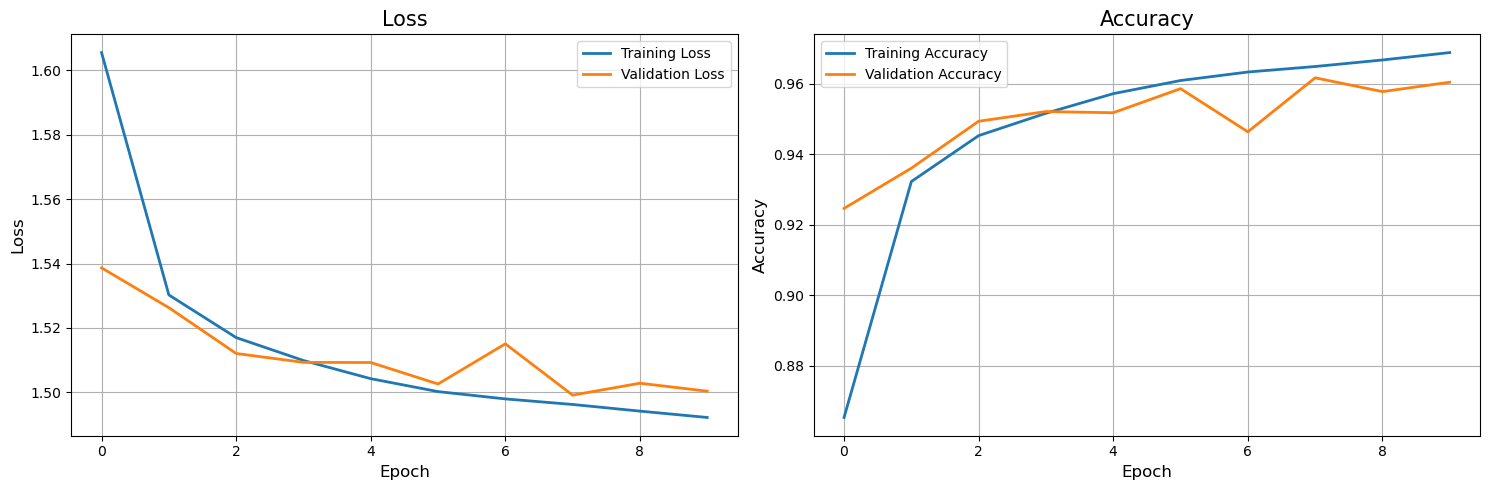

Training with params: {'num_model': 2, 'hidden_units': [100, 70, 30], 'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.0015, 'n_epochs': 10, 'batch_size': 20, 'loss_fn': CrossEntropyLoss()}
Epoch: 1 	Training Loss: 1.616457 	Training Accuracy: 0.849021
Epoch: 1 	Validation Loss: 1.532171 	Validation Accuracy: 0.930750
Epoch: 2 	Training Loss: 1.530426 	Training Accuracy: 0.931333
Epoch: 2 	Validation Loss: 1.534801 	Validation Accuracy: 0.926833
Epoch: 3 	Training Loss: 1.518226 	Training Accuracy: 0.942896
Epoch: 3 	Validation Loss: 1.518519 	Validation Accuracy: 0.942417
Epoch: 4 	Training Loss: 1.511244 	Training Accuracy: 0.949729
Epoch: 4 	Validation Loss: 1.513729 	Validation Accuracy: 0.947583
Epoch: 5 	Training Loss: 1.508021 	Training Accuracy: 0.952667
Epoch: 5 	Validation Loss: 1.511145 	Validation Accuracy: 0.949917
Epoch: 6 	Training Loss: 1.507418 	Training Accuracy: 0.953625
Epoch: 6 	Validation Loss: 1.51

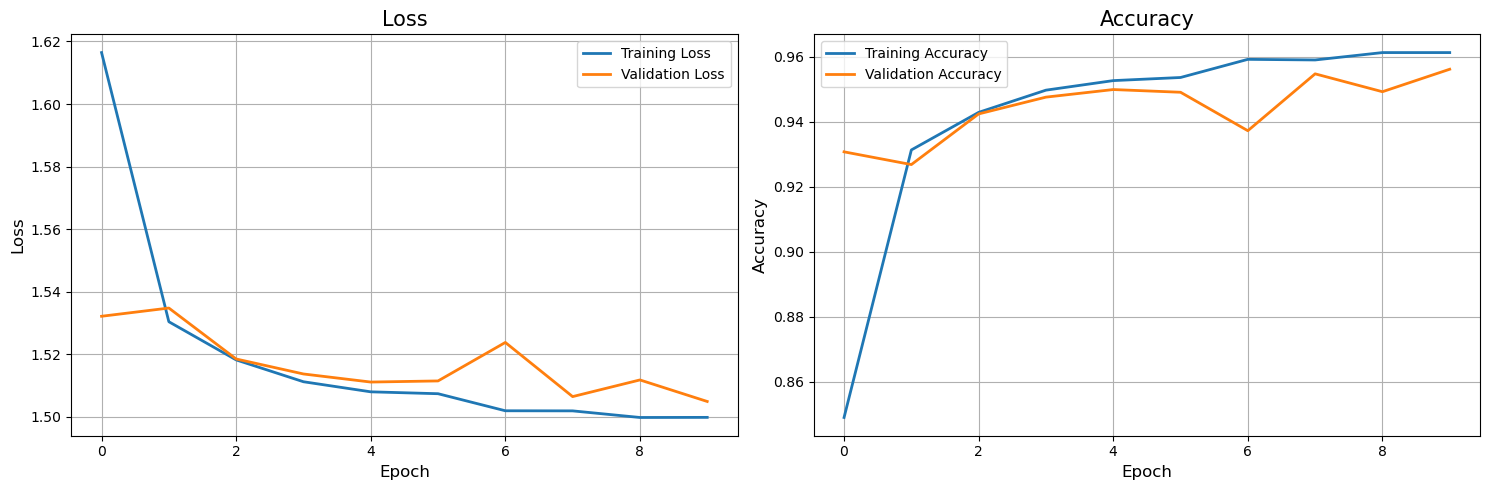

Training with params: {'num_model': 3, 'hidden_units': [100, 70, 30], 'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.002, 'n_epochs': 10, 'batch_size': 20, 'loss_fn': CrossEntropyLoss()}
Epoch: 1 	Training Loss: 1.587550 	Training Accuracy: 0.877958
Epoch: 1 	Validation Loss: 1.531640 	Validation Accuracy: 0.929083
Epoch: 2 	Training Loss: 1.529575 	Training Accuracy: 0.931521
Epoch: 2 	Validation Loss: 1.518450 	Validation Accuracy: 0.942500
Epoch: 3 	Training Loss: 1.522032 	Training Accuracy: 0.938979
Epoch: 3 	Validation Loss: 1.529438 	Validation Accuracy: 0.931250
Epoch: 4 	Training Loss: 1.518303 	Training Accuracy: 0.942542
Epoch: 4 	Validation Loss: 1.522400 	Validation Accuracy: 0.938500
Epoch: 5 	Training Loss: 1.515981 	Training Accuracy: 0.945083
Epoch: 5 	Validation Loss: 1.514336 	Validation Accuracy: 0.946333
Epoch: 6 	Training Loss: 1.517741 	Training Accuracy: 0.943354
Epoch: 6 	Validation Loss: 1.524

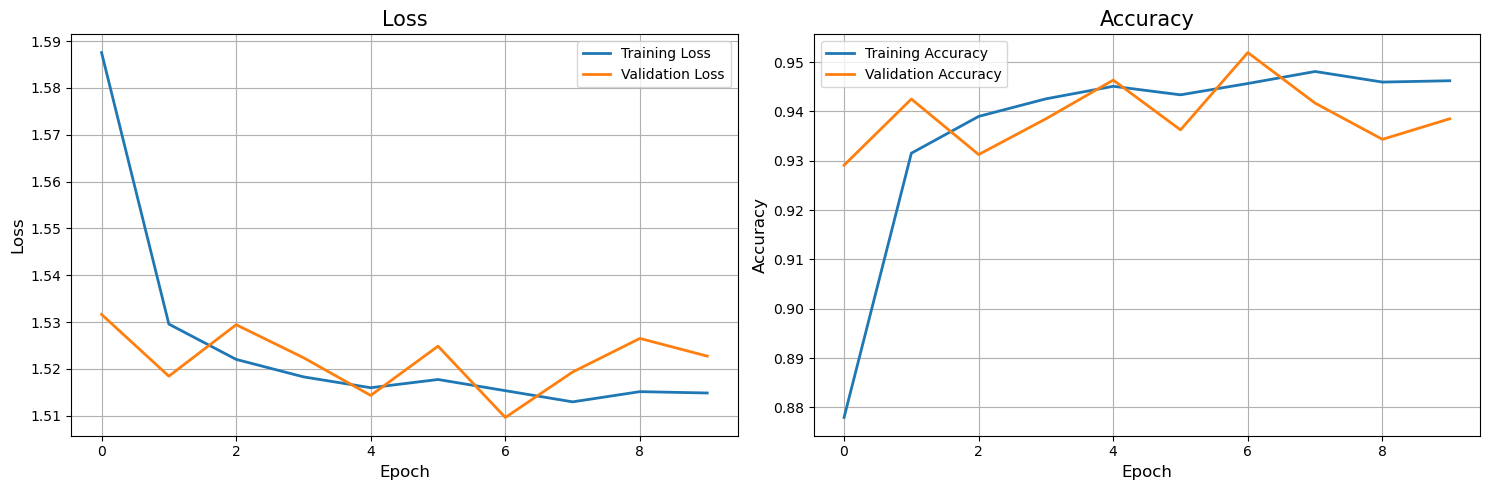

Training with params: {'num_model': 4, 'hidden_units': [100, 70, 30], 'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'n_epochs': 15, 'batch_size': 20, 'loss_fn': CrossEntropyLoss()}
Epoch: 1 	Training Loss: 1.608002 	Training Accuracy: 0.862417
Epoch: 1 	Validation Loss: 1.533251 	Validation Accuracy: 0.929917
Epoch: 2 	Training Loss: 1.526909 	Training Accuracy: 0.935917
Epoch: 2 	Validation Loss: 1.521390 	Validation Accuracy: 0.941333
Epoch: 3 	Training Loss: 1.511409 	Training Accuracy: 0.950917
Epoch: 3 	Validation Loss: 1.526527 	Validation Accuracy: 0.934833
Epoch: 4 	Training Loss: 1.504353 	Training Accuracy: 0.957417
Epoch: 4 	Validation Loss: 1.506731 	Validation Accuracy: 0.954417
Epoch: 5 	Training Loss: 1.500501 	Training Accuracy: 0.960583
Epoch: 5 	Validation Loss: 1.502725 	Validation Accuracy: 0.958917
Epoch: 6 	Training Loss: 1.497208 	Training Accuracy: 0.964042
Epoch: 6 	Validation Loss: 1.500

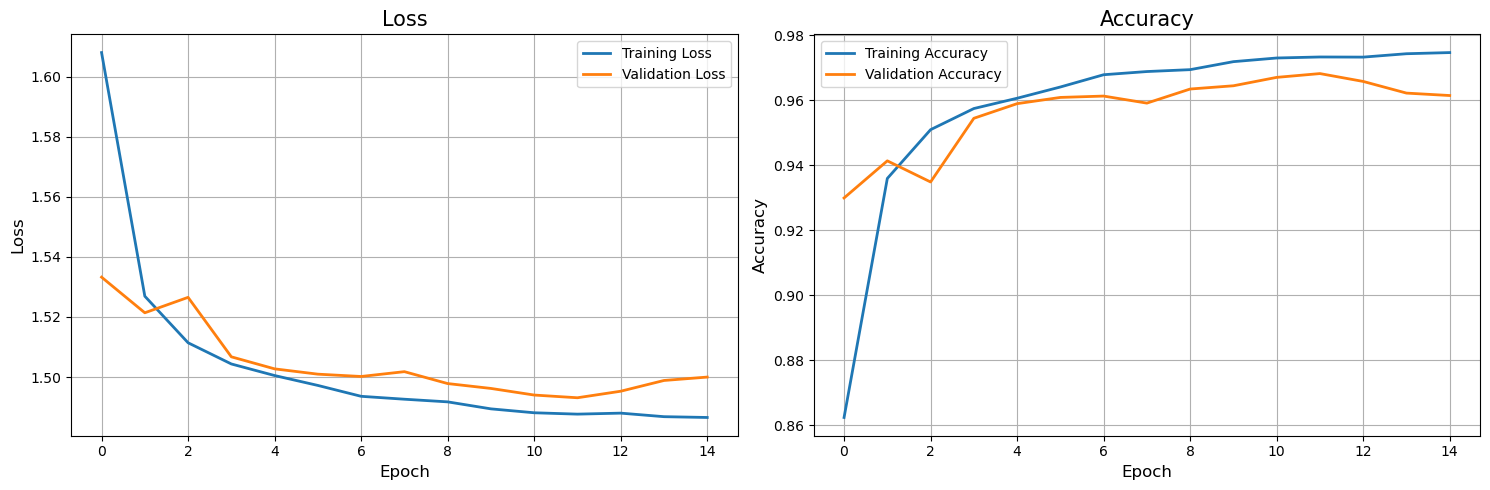

Training with params: {'num_model': 5, 'hidden_units': [100, 70, 30], 'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.0015, 'n_epochs': 15, 'batch_size': 20, 'loss_fn': CrossEntropyLoss()}
Epoch: 1 	Training Loss: 1.597027 	Training Accuracy: 0.870687
Epoch: 1 	Validation Loss: 1.529944 	Validation Accuracy: 0.933583
Epoch: 2 	Training Loss: 1.527025 	Training Accuracy: 0.935125
Epoch: 2 	Validation Loss: 1.515256 	Validation Accuracy: 0.946917
Epoch: 3 	Training Loss: 1.514945 	Training Accuracy: 0.946438
Epoch: 3 	Validation Loss: 1.517930 	Validation Accuracy: 0.943333
Epoch: 4 	Training Loss: 1.511123 	Training Accuracy: 0.950042
Epoch: 4 	Validation Loss: 1.504633 	Validation Accuracy: 0.956750
Epoch: 5 	Training Loss: 1.506201 	Training Accuracy: 0.954833
Epoch: 5 	Validation Loss: 1.515037 	Validation Accuracy: 0.946000
Epoch: 6 	Training Loss: 1.505558 	Training Accuracy: 0.955646
Epoch: 6 	Validation Loss: 1.51

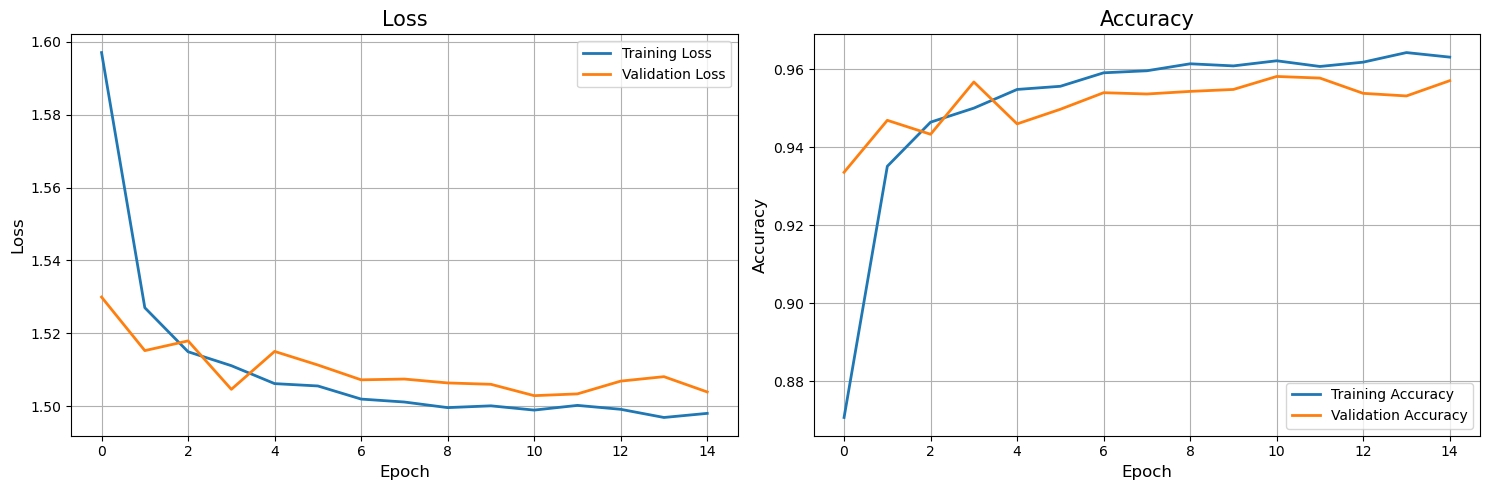

Training with params: {'num_model': 6, 'hidden_units': [100, 70, 30], 'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.002, 'n_epochs': 15, 'batch_size': 20, 'loss_fn': CrossEntropyLoss()}
Epoch: 1 	Training Loss: 1.610715 	Training Accuracy: 0.853375
Epoch: 1 	Validation Loss: 1.532956 	Validation Accuracy: 0.928333
Epoch: 2 	Training Loss: 1.532877 	Training Accuracy: 0.928375
Epoch: 2 	Validation Loss: 1.534211 	Validation Accuracy: 0.925750
Epoch: 3 	Training Loss: 1.523504 	Training Accuracy: 0.937271
Epoch: 3 	Validation Loss: 1.531235 	Validation Accuracy: 0.929750
Epoch: 4 	Training Loss: 1.523746 	Training Accuracy: 0.937187
Epoch: 4 	Validation Loss: 1.530499 	Validation Accuracy: 0.930083
Epoch: 5 	Training Loss: 1.519732 	Training Accuracy: 0.940958
Epoch: 5 	Validation Loss: 1.510374 	Validation Accuracy: 0.950417
Epoch: 6 	Training Loss: 1.516028 	Training Accuracy: 0.944875
Epoch: 6 	Validation Loss: 1.516

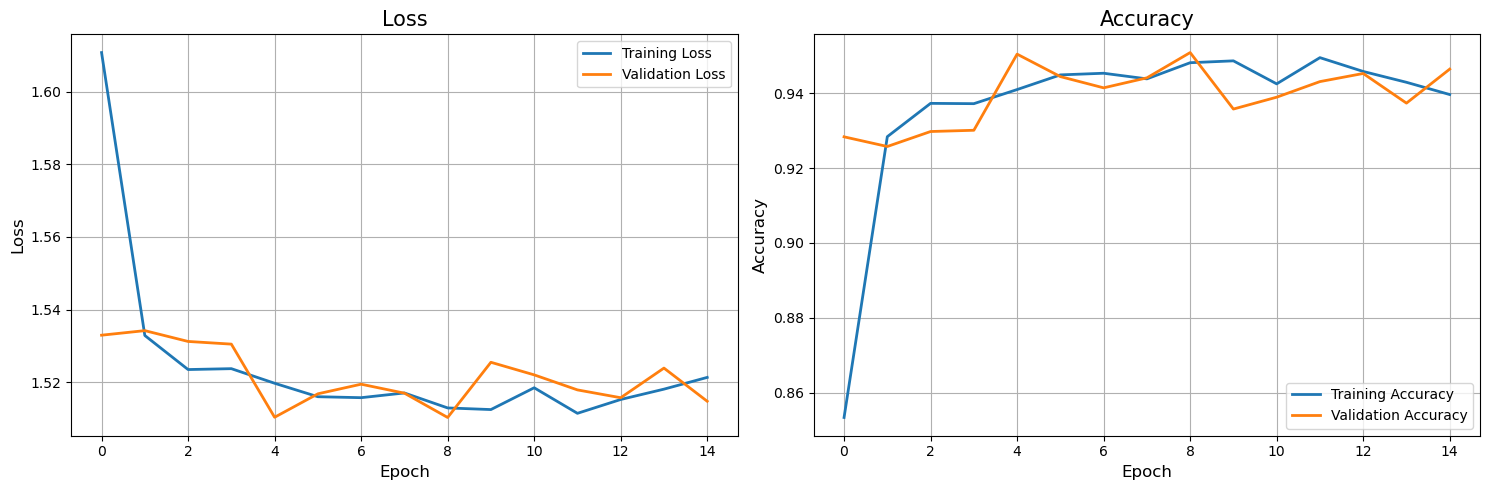

Training with params: {'num_model': 7, 'hidden_units': [100, 70, 30], 'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.001, 'n_epochs': 20, 'batch_size': 20, 'loss_fn': CrossEntropyLoss()}
Epoch: 1 	Training Loss: 1.624335 	Training Accuracy: 0.845750
Epoch: 1 	Validation Loss: 1.533736 	Validation Accuracy: 0.930083
Epoch: 2 	Training Loss: 1.529836 	Training Accuracy: 0.933604
Epoch: 2 	Validation Loss: 1.522163 	Validation Accuracy: 0.939833
Epoch: 3 	Training Loss: 1.515320 	Training Accuracy: 0.946833
Epoch: 3 	Validation Loss: 1.513770 	Validation Accuracy: 0.948167
Epoch: 4 	Training Loss: 1.508479 	Training Accuracy: 0.953542
Epoch: 4 	Validation Loss: 1.511882 	Validation Accuracy: 0.949667
Epoch: 5 	Training Loss: 1.503389 	Training Accuracy: 0.958021
Epoch: 5 	Validation Loss: 1.502857 	Validation Accuracy: 0.958417
Epoch: 6 	Training Loss: 1.499951 	Training Accuracy: 0.961521
Epoch: 6 	Validation Loss: 1.506

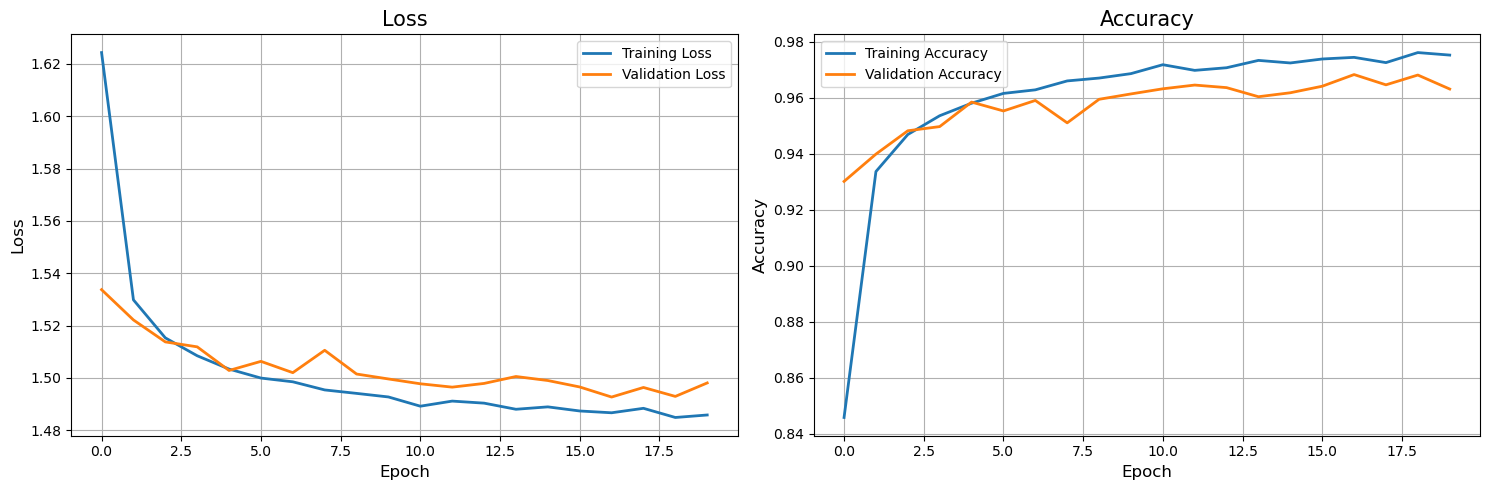

Training with params: {'num_model': 8, 'hidden_units': [100, 70, 30], 'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.0015, 'n_epochs': 20, 'batch_size': 20, 'loss_fn': CrossEntropyLoss()}
Epoch: 1 	Training Loss: 1.598437 	Training Accuracy: 0.868208
Epoch: 1 	Validation Loss: 1.551047 	Validation Accuracy: 0.912250
Epoch: 2 	Training Loss: 1.528023 	Training Accuracy: 0.933771
Epoch: 2 	Validation Loss: 1.519016 	Validation Accuracy: 0.942917
Epoch: 3 	Training Loss: 1.515522 	Training Accuracy: 0.945688
Epoch: 3 	Validation Loss: 1.517229 	Validation Accuracy: 0.944250
Epoch: 4 	Training Loss: 1.510128 	Training Accuracy: 0.951167
Epoch: 4 	Validation Loss: 1.512714 	Validation Accuracy: 0.948167
Epoch: 5 	Training Loss: 1.508959 	Training Accuracy: 0.952333
Epoch: 5 	Validation Loss: 1.506765 	Validation Accuracy: 0.954167
Epoch: 6 	Training Loss: 1.505939 	Training Accuracy: 0.955021
Epoch: 6 	Validation Loss: 1.50

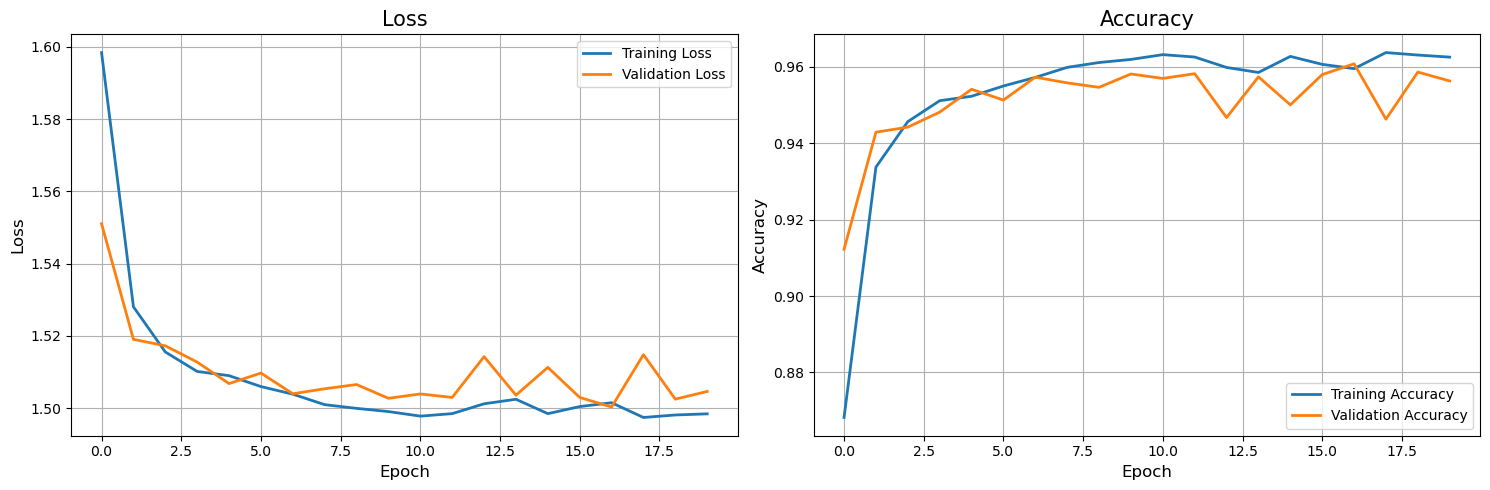

Training with params: {'num_model': 9, 'hidden_units': [100, 70, 30], 'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.002, 'n_epochs': 20, 'batch_size': 20, 'loss_fn': CrossEntropyLoss()}
Epoch: 1 	Training Loss: 1.669002 	Training Accuracy: 0.794708
Epoch: 1 	Validation Loss: 1.536309 	Validation Accuracy: 0.926083
Epoch: 2 	Training Loss: 1.531589 	Training Accuracy: 0.929646
Epoch: 2 	Validation Loss: 1.537734 	Validation Accuracy: 0.923000
Epoch: 3 	Training Loss: 1.522217 	Training Accuracy: 0.938729
Epoch: 3 	Validation Loss: 1.515352 	Validation Accuracy: 0.945833
Epoch: 4 	Training Loss: 1.518441 	Training Accuracy: 0.942438
Epoch: 4 	Validation Loss: 1.521368 	Validation Accuracy: 0.939417
Epoch: 5 	Training Loss: 1.515369 	Training Accuracy: 0.945688
Epoch: 5 	Validation Loss: 1.508617 	Validation Accuracy: 0.952417
Epoch: 6 	Training Loss: 1.513007 	Training Accuracy: 0.947958
Epoch: 6 	Validation Loss: 1.522

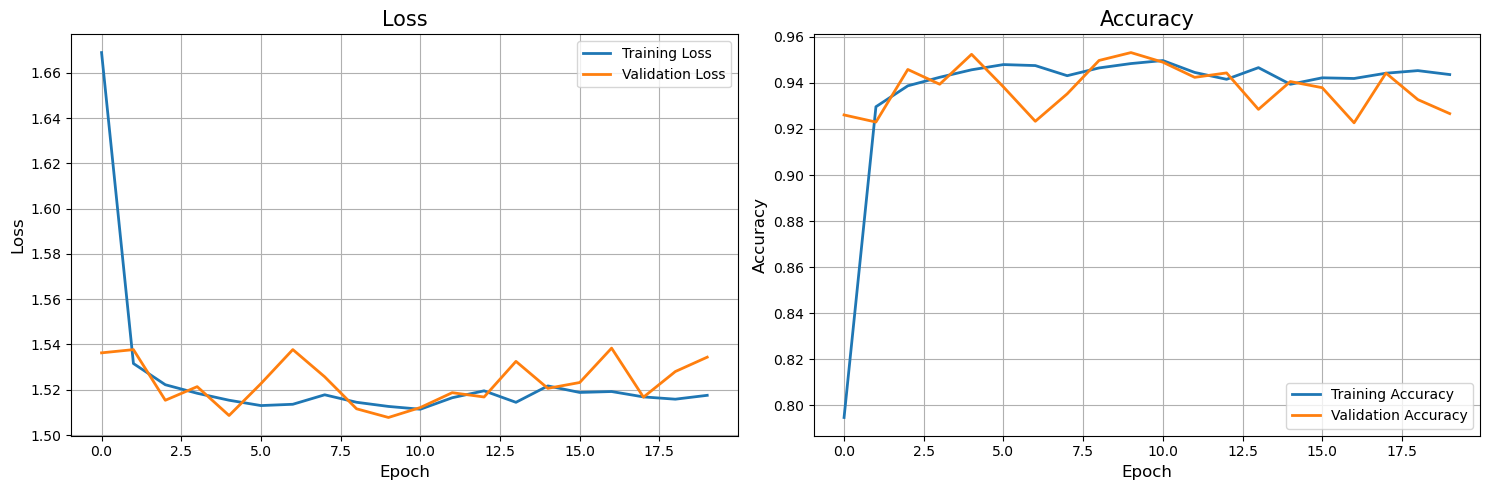

The best model in accuracy: 7 with accuracy: 0.96825
The best model in loss: 7 with loss: 1.4927006185054779


In [19]:
hyperparameters = [
    {'num_model': 1, 'hidden_units': [100, 70,30], 'activation_fn': nn.ReLU, 'optimizer': optim.Adam, 'lr': 0.001, 'n_epochs': 10, 'batch_size': 20, 'loss_fn': nn.CrossEntropyLoss()},
    {'num_model': 2, 'hidden_units': [100, 70,30], 'activation_fn': nn.ReLU, 'optimizer': optim.Adam, 'lr': 0.0015, 'n_epochs': 10, 'batch_size': 20, 'loss_fn': nn.CrossEntropyLoss()},
    {'num_model': 3, 'hidden_units': [100, 70,30], 'activation_fn': nn.ReLU, 'optimizer': optim.Adam, 'lr': 0.002, 'n_epochs': 10, 'batch_size': 20, 'loss_fn': nn.CrossEntropyLoss()},
    {'num_model': 4, 'hidden_units': [100, 70,30], 'activation_fn': nn.ReLU, 'optimizer': optim.Adam, 'lr': 0.001, 'n_epochs': 15, 'batch_size': 20, 'loss_fn': nn.CrossEntropyLoss()},
    {'num_model': 5, 'hidden_units': [100, 70,30], 'activation_fn': nn.ReLU, 'optimizer': optim.Adam, 'lr': 0.0015, 'n_epochs': 15, 'batch_size': 20, 'loss_fn': nn.CrossEntropyLoss()},
    {'num_model': 6, 'hidden_units': [100, 70,30], 'activation_fn': nn.ReLU, 'optimizer': optim.Adam, 'lr': 0.002, 'n_epochs': 15, 'batch_size': 20, 'loss_fn': nn.CrossEntropyLoss()},
    {'num_model': 7, 'hidden_units': [100, 70,30], 'activation_fn': nn.ReLU, 'optimizer': optim.Adam, 'lr': 0.001, 'n_epochs': 20, 'batch_size': 20, 'loss_fn': nn.CrossEntropyLoss()},
    {'num_model': 8, 'hidden_units': [100, 70,30], 'activation_fn': nn.ReLU, 'optimizer': optim.Adam, 'lr': 0.0015, 'n_epochs': 20, 'batch_size': 20, 'loss_fn': nn.CrossEntropyLoss()},
    {'num_model': 9, 'hidden_units': [100, 70,30], 'activation_fn': nn.ReLU, 'optimizer': optim.Adam, 'lr': 0.002, 'n_epochs': 20, 'batch_size': 20, 'loss_fn': nn.CrossEntropyLoss()},
]

# Training and validating multiple models
best_model_min_loss = None
best_model_max_accuracy = None
best_val_loss = float('inf')
best_val_accuracy = 0.0
best_model_loss=0
best_model_accuracy=0
for params in hyperparameters:

    print(f"Training with params: {params}")
    model = get_model((1, 28, 28), params['hidden_units'], params['activation_fn'])
    optimizer = params['optimizer'](model.parameters(), lr=params['lr'])
    train_loader = DataLoader(mnist_train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(mnist_val_dataset, batch_size=params['batch_size'], shuffle=False)


    model, train_accuracy_list, train_loss_list, val_accuracy_list, val_loss_list = model_train(
        params['n_epochs'], train_loader, val_loader, model, optimizer, params['loss_fn'])

    if min(val_loss_list) < best_val_loss:
        best_val_loss = min(val_loss_list)
        best_model_min_loss = model
        best_model_loss=params['num_model']

    if max(val_accuracy_list) > best_val_accuracy and max(val_accuracy_list) < 1.0:
        best_val_accuracy = max(val_accuracy_list)
        best_model_max_accuracy = model
        best_model_accuracy=params['num_model']

    plot_charts(train_accuracy_list, train_loss_list, val_accuracy_list, val_loss_list)

print(f'The best model in accuracy: {best_model_accuracy} with accuracy: {best_val_accuracy}')
print(f'The best model in loss: {best_model_loss} with loss: {best_val_loss}')

## Training Conclusions

"After experimenting with the models and hyperparameters, the best result was obtained from line 7:   
{'num_model': 7, 'hidden_units': [100, 70,30], 'activation_fn': nn.ReLU, 'optimizer': optim.Adam, 'lr': 0.001, 'n_epochs': 20, 'batch_size': 20, 'loss_fn': nn.CrossEntropyLoss()},

Or simply put:

- **hidden_units**: (100, 70, 30)
  - (Number of layers = 3, hidden_size_layer1 = 100, hidden_size_layer2 = 70, hidden_size_layer3 = 30)
  - The model will have three hidden layers. The first hidden layer has 100 units. The second hidden layer has 70 units. The third hidden layer has 30 units.

- **num_epochs**: 20

- **batch_size**: 20

- **learning_rate**: 0.001

- **loss_fn**: CrossEntropyLoss

- **optimizer**: Adam

- **activation_fn**: ReLU


# *The Test*

Epoch: 1 	Test Loss: 1.496521 	Test Accuracy: 0.964300
Epoch: 2 	Test Loss: 1.496521 	Test Accuracy: 0.964300
Epoch: 3 	Test Loss: 1.496521 	Test Accuracy: 0.964300
Epoch: 4 	Test Loss: 1.496521 	Test Accuracy: 0.964300
Epoch: 5 	Test Loss: 1.496521 	Test Accuracy: 0.964300
Epoch: 6 	Test Loss: 1.496521 	Test Accuracy: 0.964300
Epoch: 7 	Test Loss: 1.496521 	Test Accuracy: 0.964300
Epoch: 8 	Test Loss: 1.496521 	Test Accuracy: 0.964300
Epoch: 9 	Test Loss: 1.496521 	Test Accuracy: 0.964300
Epoch: 10 	Test Loss: 1.496521 	Test Accuracy: 0.964300
Epoch: 11 	Test Loss: 1.496521 	Test Accuracy: 0.964300
Epoch: 12 	Test Loss: 1.496521 	Test Accuracy: 0.964300
Epoch: 13 	Test Loss: 1.496521 	Test Accuracy: 0.964300
Epoch: 14 	Test Loss: 1.496521 	Test Accuracy: 0.964300
Epoch: 15 	Test Loss: 1.496521 	Test Accuracy: 0.964300
Epoch: 16 	Test Loss: 1.496521 	Test Accuracy: 0.964300
Epoch: 17 	Test Loss: 1.496521 	Test Accuracy: 0.964300
Epoch: 18 	Test Loss: 1.496521 	Test Accuracy: 0.964300
E

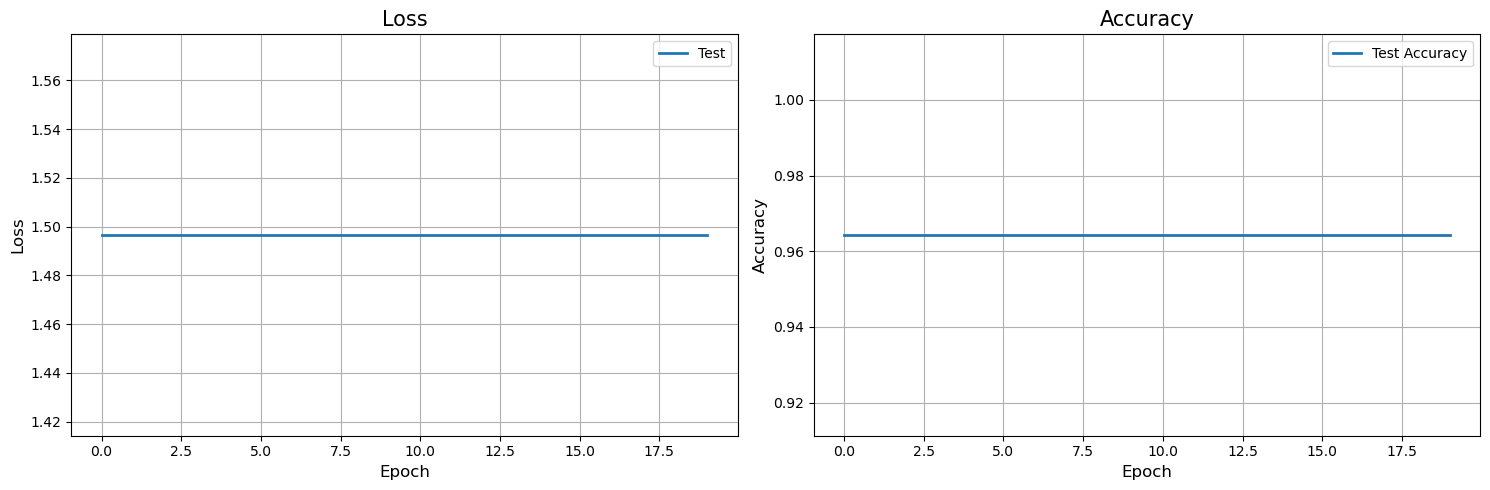

In [26]:
test_loader = DataLoader(mnist_test_dataset, batch_size=hyperparameters[7]['batch_size'], shuffle=False)

model, test_accuracy_list, test_loss_list = test(hyperparameters[7]['n_epochs'], best_model_max_accuracy, test_loader, hyperparameters[7]['loss_fn'])

plot_charts_test(test_accuracy_list, test_loss_list)

# *Conclusion*

After running the test, it is visible that the accuracy of the test, validation, and training are close, meaning overfitting and underfitting were successfully avoided.